# Восстановление изображений
Старый файл с основными методами восстановления.

Время работы: 18с

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2
from numpy.fft import fftn, ifftn

from skimage import color, data, restoration

import numpy as np
from skimage import color, data, img_as_float, io
from scipy.signal import convolve2d

from functools import partial
from scipy.optimize import minimize

from util import *
from richardson_lucy import *

In [36]:
astro = color.rgb2gray(data.astronaut())
prefix = "pic/deconv"

In [37]:
def plot_triptih(images, titles=('Original', 'Distorted', 'Restored')):
    # Support method for plotting images (orignal, distorted, restored)
    n = len(images)
    m = len(titles)
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(20, 10))
    plt.gray()
    for a in ax:
           a.axis('off')

    for i,I in enumerate(images):
        ax[i].imshow(I)
        if i<m:
            ax[i].set_title(titles[i])

    fig.subplots_adjust(wspace=0.02, hspace=0.02,
                        top=0.9, bottom=0.05, left=0, right=1)

    plt.show()

In [48]:
shift = 10
psf = motion_blur_psf_my(shift, pi/3)
astro_blurred = convolve2d(astro, psf, 'same')
astro_blurred += 1e-3 * np.random.standard_normal(astro_blurred.shape)#astro_blurred.std()
npArrayToPng(astro_blurred, "{0}-astro-shift10.png".format(prefix))

0 0 5.000000000000001 8.660254037844386


# Инверсная фильтрация

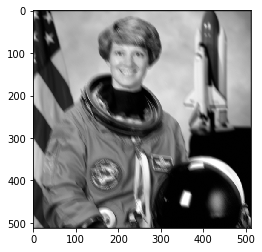

In [49]:
plt.imshow(astro_blurred, 'gray')
plt.show()

In [50]:
psf2 = np.zeros(astro_blurred.shape)
psf2[:psf.shape[0], :psf.shape[1]] = psf

In [51]:
astro_restored = ifftn(fftn(astro_blurred)/psf2otf(psf, astro_blurred.shape))
#astro_restored = ifftn(fftn(astro_blurred)/fftn(psf2))
astro_restored = np.clip(np.abs(astro_restored),0, 1)
npArrayToPng(astro_restored, "{0}-inverse-filter.png".format(prefix))

19.21471748307505


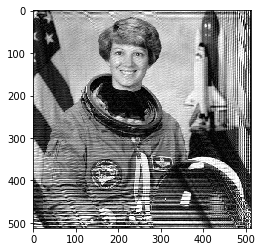

In [52]:
print(compare_psnr_crop(astro, astro_restored))
plt.imshow(astro_restored, 'gray')
plt.show()

## Unsupervised wiener
box 10x10 filter

0 0 7.500000000000002 12.990381056766578


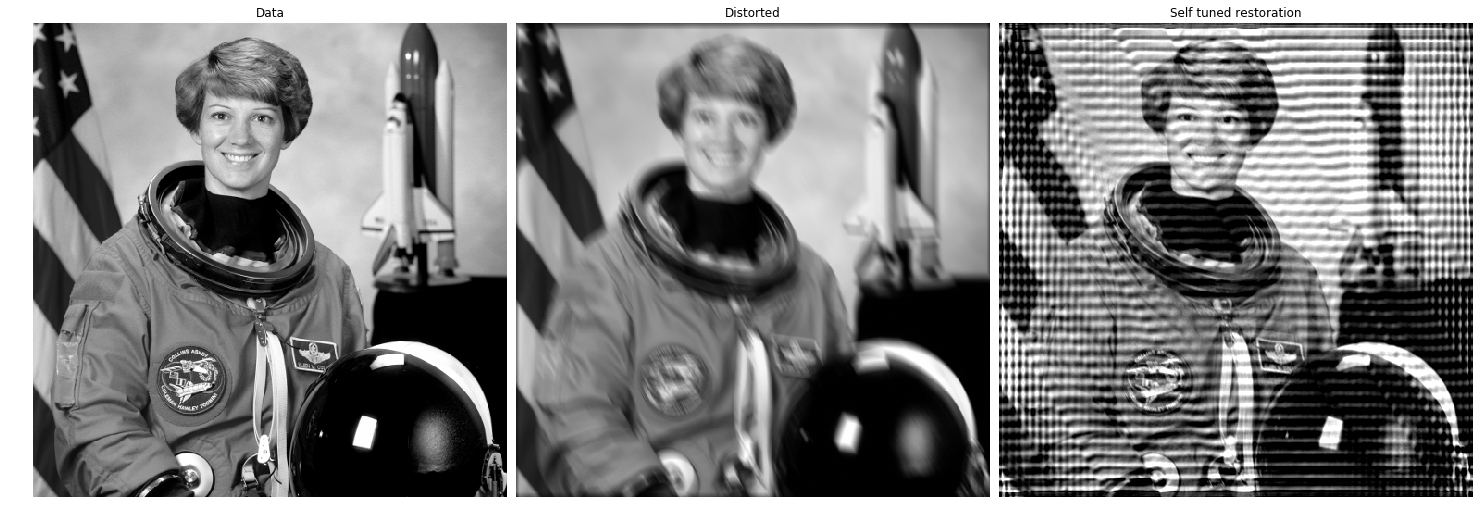

16.506596860810355


In [55]:
shift = 15
psf = motion_blur_psf_my(shift, pi/3)
astro_distorted = conv2(astro, psf, 'same')
astro_distorted += 0.001 * np.random.standard_normal(astro_distorted.shape)# * astro_distorted.std()

deconvolved, _ = restoration.unsupervised_wiener(astro_distorted, psf)
deconvolved = np.clip(deconvolved, 0, 1)

plot_triptih((astro, astro_distorted, deconvolved),
            ('Data', 'Distorted', 'Self tuned restoration'))
npArrayToPng(astro_distorted, "{0}-shift15.png".format(prefix))
npArrayToPng(deconvolved, "{0}-shift15-restored-u-wiener.png".format(prefix))
print(compare_psnr_crop(astro, deconvolved))

In [10]:
import skimage.data
from skimage import img_as_float
img = img_as_float(skimage.data.camera())
sigma = 0.1
img = img + sigma * np.random.standard_normal(img.shape)
sigma_hat = restoration.estimate_sigma(img, multichannel=False)
sigma, sigma_hat

(0.1, 0.10058649325127879)

## Wiener
box 10x10

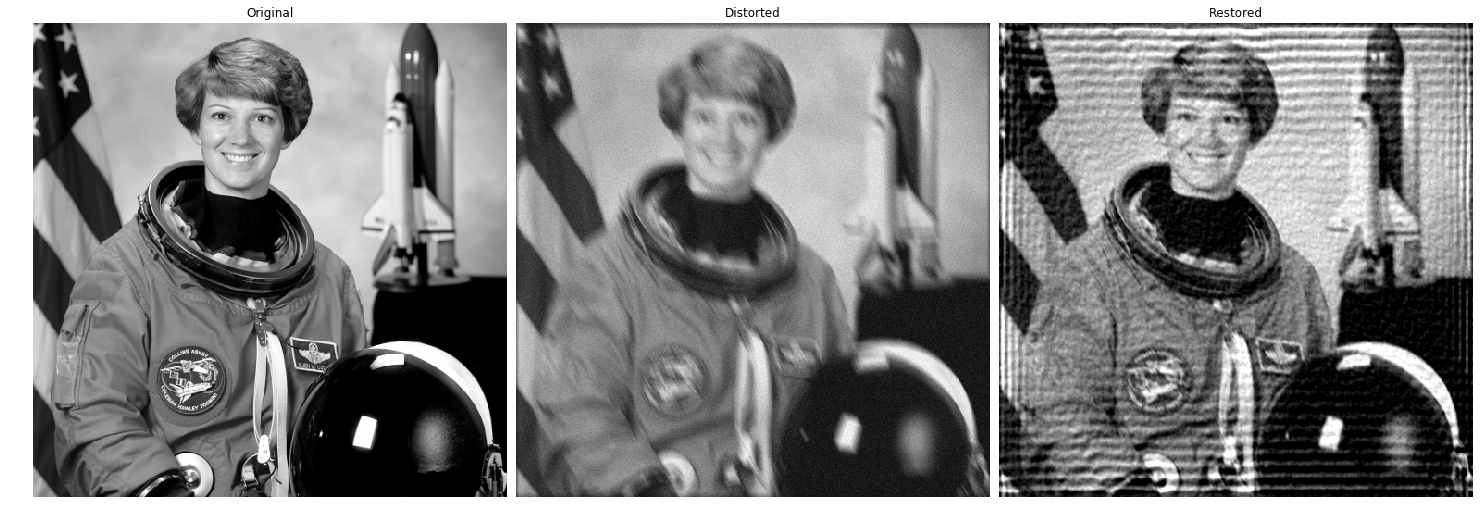

In [11]:
astro_distorted = convolve2d(astro, psf, 'same')
astro_distorted += 0.1 * astro_distorted.std() * np.random.standard_normal(astro_distorted.shape)
deconvolved_img = restoration.wiener(astro_distorted, psf, 1)
deconvolved_img = np.clip(deconvolved, 0, 1)

plot_triptih((astro, astro_distorted, deconvolved_img))

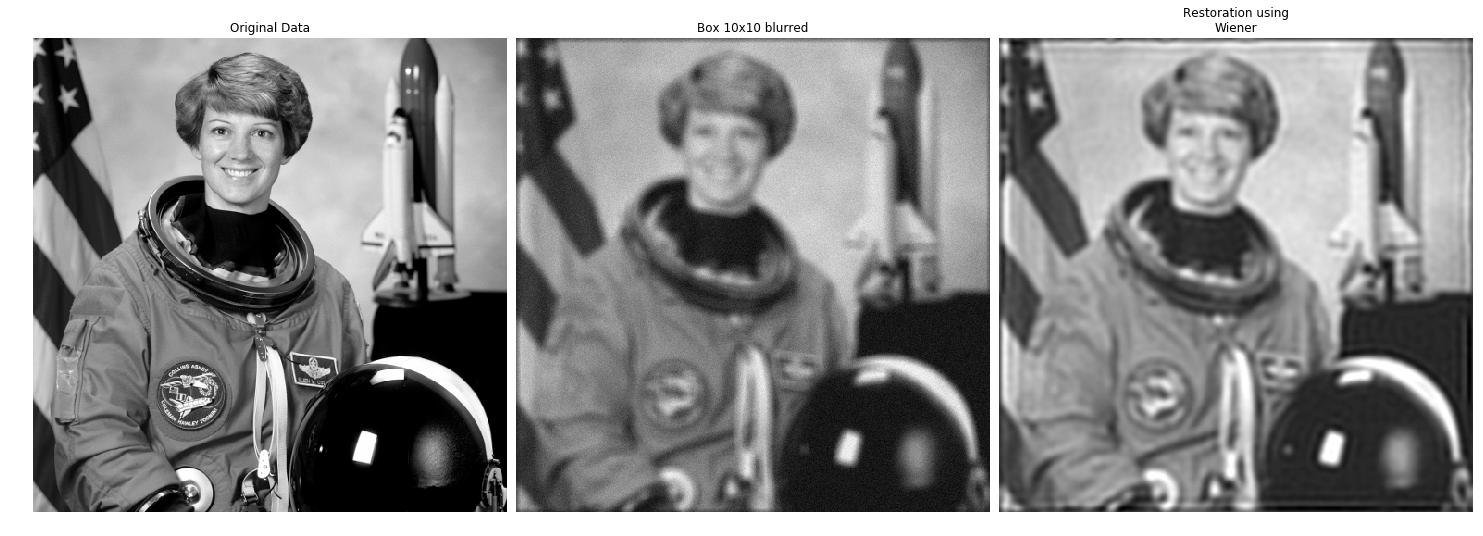

In [12]:
astro = color.rgb2gray(data.astronaut())
N = 10
psf = np.ones((N, N)) / N**2
astro_distorted = convolve2d(astro, psf, 'same')
astro_distorted += 0.1 * astro_distorted.std() * np.random.standard_normal(astro_distorted.shape)

#sigma_hat = restoration.estimate_sigma(I_noised, multichannel=False)

deconvolved_img = restoration.wiener(astro_distorted, psf, 1)

plot_triptih((astro, astro_distorted, deconvolved_img),
             ('Original Data', 'Box {0}x{0} blurred'.format(N), 'Restoration using\nWiener'))

## Lucy-Richardson
box 10x10 filter

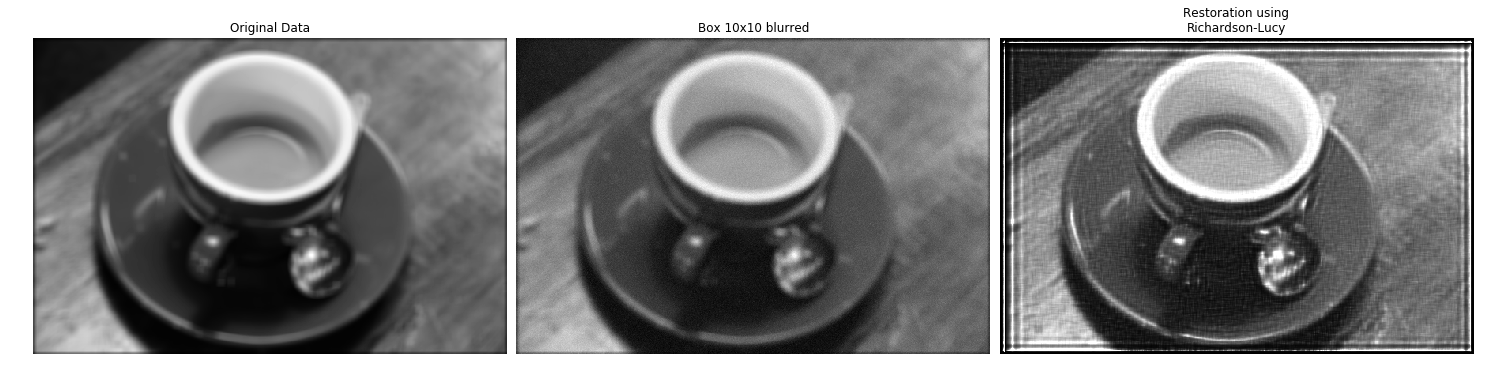

In [13]:
astro = color.rgb2gray(data.coffee())#color.rgb2gray(data.astronaut())
N = 10
psf = np.ones((N, N)) / N**2
astro = conv2(astro, psf, 'same')
# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=30)

plot_triptih((astro, astro_noisy, deconvolved_RL),
             ('Original Data', 'Box {0}x{0} blurred'.format(N), 'Restoration using\nRichardson-Lucy'))

Motion blur (x+=20) filter

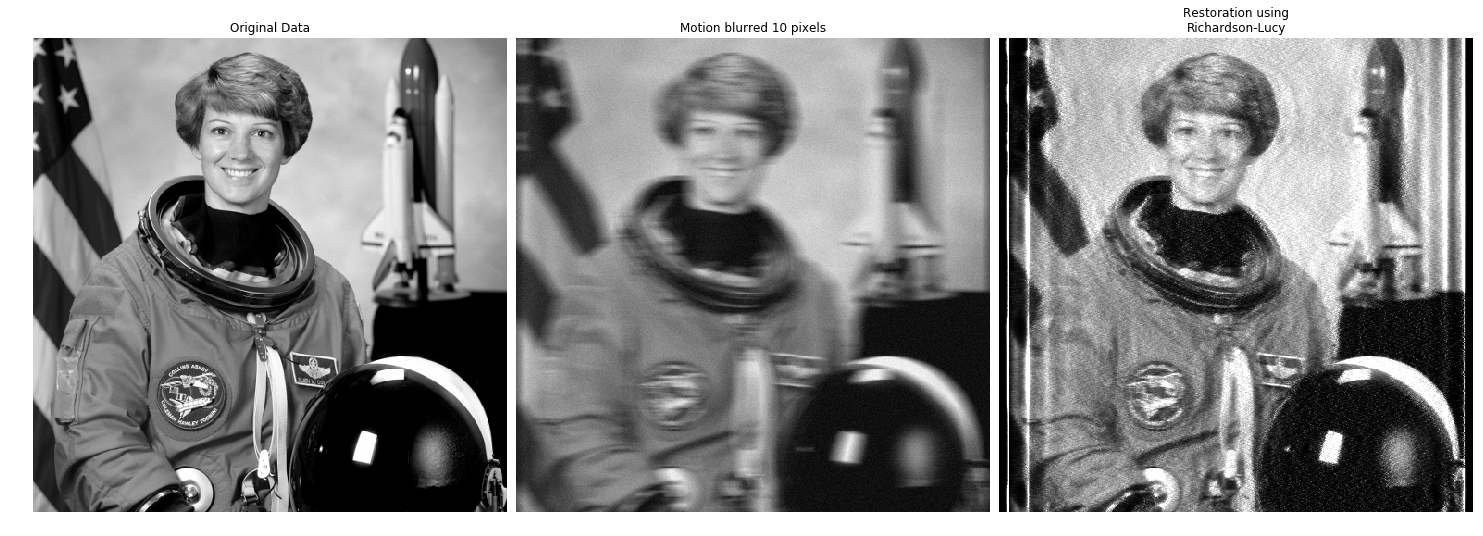

In [14]:
I = color.rgb2gray(data.astronaut())
mv = 20
psf_mv = np.ones((1,mv))/mv
I_moved = conv2(I, psf_mv, 'same')

# Add Noise to Image
I_noised = I_moved.copy()
I_noised += (np.random.poisson(lam=25, size=I_noised.shape) - 10) / 255.

#mv -=14
#psf_mv = np.ones((1,mv))/mv
deconvolved_RL = restoration.richardson_lucy(I_noised, psf_mv, iterations=50)

plot_triptih((I, I_noised, deconvolved_RL),
             ('Original Data', 'Motion blurred {0} pixels'.format(N), 'Restoration using\nRichardson-Lucy'))

In [15]:
def gauss2dKernel(sigma, size=3):
    # First a 1-D  Gaussian
    t = np.linspace(-(size-1)/2., (size-1)/2., size)
    bump = np.exp(-t**2/(2*sigma**2))
    return bump[:, np.newaxis] * bump[np.newaxis, :] / (2*np.pi*sigma**2)

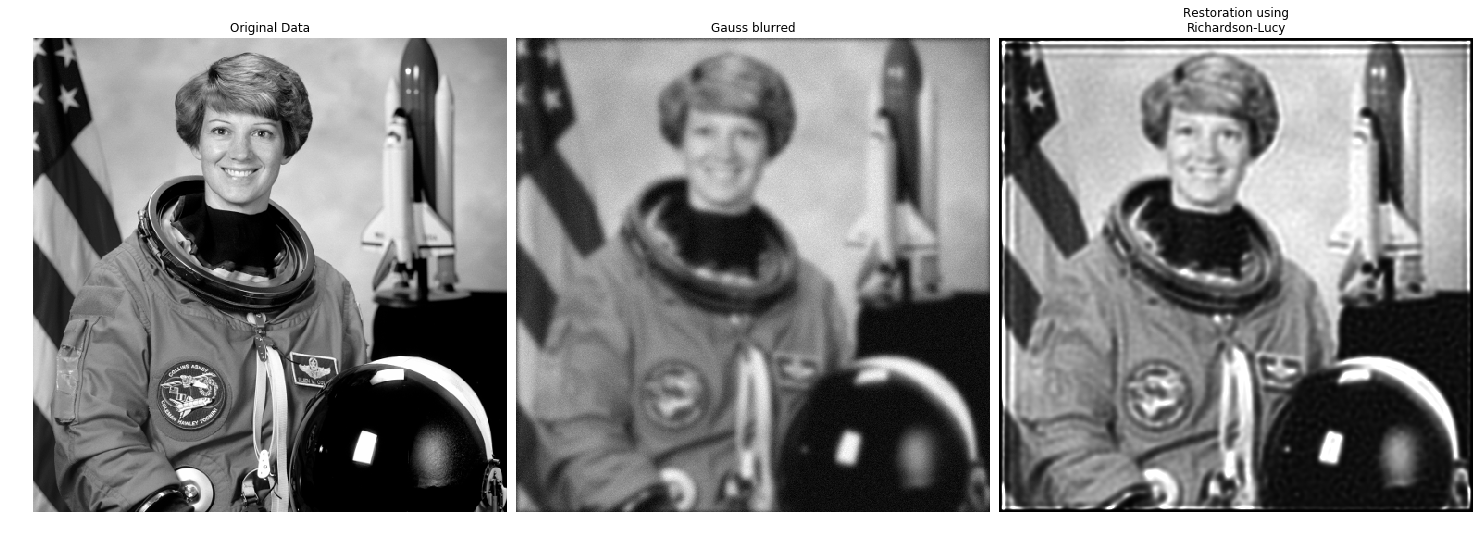

In [16]:
I = color.rgb2gray(data.astronaut())

psf_mv = gauss2dKernel(3, 20)
I_moved = conv2(I, psf_mv, 'same')

# Add Noise to Image
I_noised = I_moved.copy()
I_noised += (np.random.poisson(lam=25, size=I_noised.shape) - 10) / 255.

deconvolved_RL = restoration.richardson_lucy(I_noised, psf_mv, iterations=30)

plot_triptih((I, I_noised, deconvolved_RL),
             ('Original Data', 'Gauss blurred', 'Restoration using\nRichardson-Lucy'))